# Diversity in Milan neightborhood appeal
We are going to classify every Milan neightborhood based on:
- Cultural venues
- Food related venues (except restaurants)
- Health and Care venues
- Naturalistic and interesting buildings attractions
- Restaurants
- Shopping venues
- Spare time activities
- Sport
- Transport

We will than compare rent and purchase prices for homes in Milan.

> To do that we downloaded, interpolated and webscraped many content from http://dati.comune.milano.it/ , https://immobiliare.it and https://www.foursquare.com

In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
from sklearn.cluster import KMeans
import folium
import requests
import geocoder
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

NEIGHTBORHOOD_FILE = 'milan_data/quartieri.geojson';
NEIGHTBORHOOD_ITEMS_FILE = 'milan_data/quartieri-centroidi.json';
VENUES_FILE = 'milan_data/venues-info.csv';
NEIGHTBORHOOD_ITEMS = []
PLACE = [45.464161, 9.190336]
FOURSQUARE_CLIENT_ID = '???' 
FOURSQUARE_CLIENT_SECRET = '???' 

> **A note about performance**
In this notebook I had to save the ouput of my queries into many files in order to have better performance when a reload was needed. I have commented the original source code so you can uncomment the code to perform the query by your own.

### Finding neightborhood centers
Despite some approximation I found useful asking `arcgis` che neightborhood name by itself in order to obtain latitude and longitude.

`Arcgis` failed some query, so I added manualy some points directly into the `.json` file I saved.
You can find the final output of `arcgis` query plus my manual integration into `milan_data/quartieri-centroidi.json`

In [2]:
'''
# Original Query
with open(NEIGHTBORHOOD_FILE) as json_file:
    data = json.load(json_file)
    for p in data['features']:
        name = p['properties']['NIL']
        geocoderPosition = geocoder.arcgis(location = '{}, Milano, Italia'.format(name)).json
        if geocoderPosition['ok'] == True:
            item = { 'name': name, 'lat': geocoderPosition['lat'], 'lng': geocoderPosition['lng'] }
        else:
            item = { 'name': name, 'lat': None, 'lng': None }
        NEIGHTBORHOOD_ITEMS.append(item)'''

# Cached Query + manual integrations
with open(NEIGHTBORHOOD_ITEMS_FILE) as json_file:
    NEIGHTBORHOOD_ITEMS = json.load(json_file)
neightborhood_df = pd.read_json(NEIGHTBORHOOD_ITEMS_FILE)
neightborhood_df = neightborhood_df[['name', 'lat', 'lng']]
neightborhood_df.head()

name        lat       lng
0        SACCO  45.464600  9.152800
1     COMASINA  45.526400  9.159900
2   STEPHENSON  45.512744  9.114172
3         QT 8  45.486030  9.138410
4  ORTOMERCATO  45.465090  9.183900

Neightborhood differs for many reason. Area is one of them.

Let's imagine every neightborhood as a circle:

In [3]:
import math
nAreas = {};
with open(NEIGHTBORHOOD_FILE) as json_file:
    f = json.load(json_file)
    for n in f['features']:
        nAreas[n["properties"]["NIL"]] = n["properties"]["AreaMQ"]
neightborhood_df["AreaMQ"] = neightborhood_df["name"].map(lambda x: nAreas[x])
neightborhood_df["Radius"] = neightborhood_df["AreaMQ"].map(lambda x: int(math.sqrt(x/math.pi)))
neightborhood_df["Radius Normalized"] = neightborhood_df["Radius"].map(lambda x: x / neightborhood_df["Radius"].max())

# Draw a map
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHTBORHOOD_FILE, data=neightborhood_df,  
             columns=['name', 'AreaMQ'],
             key_on='feature.properties.NIL',
             fill_color='YlOrRd',
             fill_opacity=0.6,
             line_opacity=0.1,
             highlight = True,
             legend_name='Neighborhood surface')

for item in NEIGHTBORHOOD_ITEMS:
    label = '{}'.format(item['name'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [item['lat'], item['lng']],
        radius=18*neightborhood_df[neightborhood_df['name'] == item['name']]['Radius Normalized'].values[0],
        popup=label,
        color='white',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Foursquare for finding venues
I opened a developer account on Foursquare to collect data about venues in Milan.
As before, i cached the Foursquare output into `'milan_data/venues-info.csv'`.


### Data cleaning
Because Foursquare data was not general enought i split those data in some categories with Microsoft Excel. You can find the conversion file into `tabella-riconversione.xlsx`.

This was my process:
1. I loaded the data from Foursquare api as a CSV;
2. I trimmed and cleaned al the data;
3. I grouped manually every `Venues category` into a general category
4. I grouped manually every general category into a more general category

In [4]:
'''
# Original Query
from pandas.io.json import json_normalize
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng, circleR in zip(names, latitudes, longitudes, radius):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&radius={}&limit={}&v=20190527'.format(FOURSQUARE_CLIENT_ID, FOURSQUARE_CLIENT_SECRET, lat, lng, circleR, 100)
        r = requests.get(url).json()["response"]
        if 'groups' in r:
            results = r['groups'][0]['items']
            venues_list.append([(name, lat, lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 v['venue']['location']['postalCode'] if 'postalCode' in v['venue']['location'] else -1,
                                 v['venue']['location']['formattedAddress'][0],
                             v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 'Postal Code', 'Address',
                  'Venue Category']
    return(nearby_venues)

venues = getNearbyVenues(names=neightborhood_df['name'], latitudes=neightborhood_df['lat'], longitudes=neightborhood_df['lng'], radius=neightborhood_df['Radius'])
venues.to_csv(r'milan_data/venues-info.csv')
venues.shape
'''

venues = pd.read_csv(VENUES_FILE)
venues.drop('Unnamed: 0', axis = 1, inplace = True)
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        SACCO                45.4646                  9.1528   
1        SACCO                45.4646                  9.1528   
2        SACCO                45.4646                  9.1528   
3        SACCO                45.4646                  9.1528   
4        SACCO                45.4646                  9.1528   

                   Venue  Venue Latitude  Venue Longitude Postal Code  \
0       Teatro Nazionale       45.466736         9.153980       20145   
1                 Nove25       45.467409         9.152414       20149   
2  Ristorante Casa Lucia       45.467483         9.152844       20149   
3             Orea Malià       45.467687         9.153120       20146   
4             Koalasport       45.463437         9.149065       20146   

                                            Address       Venue Category  
0                                Piazza Piemonte 12              Theater  
1                                     Via Ravizza 3        Jewelry Store  
2                                     Via Ravizza 2   Italian Restaurant  
3  via Marghera, 18 (cortile interno) (via Ravizza)   Salon / Barbershop  
4                               Via Dei Gracchi, 26  Sporting Goods Shop

Because working with Pandas and Excel file togheter is slow too, I decided to cache my transform layer too.

I rewrote the `venues` dataframes with my transformed layer:

In [5]:
'''
# Original Query
transform_layer = pd.read_excel(r'milan_data/tabella-riconversione.xlsx', sheet_name = "Relazioni")
transform_layer['Trimmed data'] = transform_layer['Trimmed data'].str.strip()
venues['Venue Category'] = venues['Venue Category'].str.strip()
def TL(c):
    try:
        return transform_layer[transform_layer['Trimmed data'] == c].ReversedData.values[0]
    except:
        return print(c)
venues['Venue Category'] = venues['Venue Category'].map(TL)
venues['Macro Category'] = venues['Venue Category'].map(lambda c: transform_layer[transform_layer['ReversedData'] == c].Macrocategory.values[0])
venues.to_csv(r'milan_data/venues-info-detailed.csv')
'''

venues = pd.read_csv('milan_data/venues-info-detailed.csv')
venues.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        SACCO                45.4646                  9.1528   
1        SACCO                45.4646                  9.1528   
2        SACCO                45.4646                  9.1528   
3        SACCO                45.4646                  9.1528   
4        SACCO                45.4646                  9.1528   

                   Venue  Venue Latitude  Venue Longitude Postal Code  \
0       Teatro Nazionale       45.466736         9.153980       20145   
1                 Nove25       45.467409         9.152414       20149   
2  Ristorante Casa Lucia       45.467483         9.152844       20149   
3             Orea Malià       45.467687         9.153120       20146   
4             Koalasport       45.463437         9.149065       20146   

                                            Address           Venue Category  \
0                                Piazza Piemonte 12                  Theater   
1                                     Via Ravizza 3                Gift Shop   
2                                     Via Ravizza 2       Italian Restaurant   
3  via Marghera, 18 (cortile interno) (via Ravizza)  Health & Beauty Service   
4                               Via Dei Gracchi, 26                    Goods   

   Macro Category  
0         Culture  
1        Shopping  
2      Restaurant  
3  Helth and Care  
4           Sport

## House prices with Immobiliare.it

I webscraped with `BeautifulSoup` Immobiliare.it in order to obtain house prices in Milan.

I initially tried to obtain prices for every venue's street but Immobiliare didn't let me do that, so I decided to use this data only to obtain some aggregated content.

After I ended webcraping, I found that some data was missing - I used other house prices website to add the missing information manually.

All the edit in this step was made directly inside the `milan_data/house-prices.csv`

In [6]:
'''
# Web scraper
from bs4 import BeautifulSoup
def addressNormalizer(address):
    workItem = address
    if ',' in workItem:
        workItem = workItem.split(',')[0]
    if '(' in workItem:
        workItem = workItem.split('(')[0]
    workItem = workItem.strip()
    workItem = ''.join([i for i in workItem if not i.isdigit()])
    return workItem.strip().lower()

venues_withcap = venues.loc[venues['Postal Code'] != "-1"]
venues_withcap['Address Map'] = venues_withcap.Address.map(lambda x: addressNormalizer(x))
ORIGINAL_NAMES = []
ORIGINAL_ADDRESS = []
CAPS = []
NBOR = []
SELLPRICE = []
LOANPRICE = []
i = 0
for address in venues_withcap["Address Map"].unique():
    w = address.replace(' ', '-')
    if '.' not in w and '/' not in w and '\'' not in w:
        elem = venues_withcap[venues_withcap['Address Map'] == address].iloc[0]
        cap = elem['Postal Code']
        CAPS.append(cap)
        ORIGINAL_NAMES.append(w)
        ORIGINAL_ADDRESS.append(address)
        NBOR.append(elem['Neighborhood'])
        soup = BeautifulSoup(requests.get("https://www.immobiliare.it/mercato-immobiliare/lombardia/milano/{}-{}/".format(w, cap)).text, 'html.parser')
        tokens = soup.body.select('p.nd-cgHighlighted__text')
        if(tokens is not None and len(tokens) >= 2):
            SELLPRICE.append(soup.body.select('p.nd-cgHighlighted__text')[0].get_text())
            LOANPRICE.append(soup.body.select('p.nd-cgHighlighted__text')[1].get_text())
        else:
            SELLPRICE.append(0)
            LOANPRICE.append(0)
house_prices = pd.DataFrame.from_dict({'Address Recognizer': ORIGINAL_NAMES,
        'Cap': CAPS,
        'Address': ORIGINAL_ADDRESS,
        'Neighborhood': NBOR,
        'Sell Price': SELLPRICE,
        'Loan Price': LOANPRICE
       })
house_prices.to_csv(r'milan_data/house-prices.csv')
'''

# Cached prices + information I added manually
house_prices = pd.read_csv(r'milan_data/house-prices-edited.csv', sep=';')
house_prices = house_prices[house_prices['Sell Price'] > 0]
hpriceg = house_prices.groupby(by = "Neighborhood").agg({
    'Sell Price' : ['min', 'max', 'mean'],
    'Loan Price' : ['min', 'max', 'mean']
})

hpriceg.head()

Sell Price                      Loan Price              
                    min     max         mean        min    max   mean
Neighborhood                                                         
ADRIANO          2450.0  2450.0  2450.000000       7.75   7.75   7.75
AFFORI           2532.0  2532.0  2532.000000       7.38   7.38   7.38
BAGGIO           2257.0  2257.0  2257.000000       7.00   7.00   7.00
BANDE NERE       2300.0  4044.0  2782.666667       8.25  13.26   9.71
BARONA           2563.0  2563.0  2563.000000      10.25  10.25  10.25

I've added some more info manually, so load the new file:

In [7]:
house_prices = pd.read_csv(r'milan_data/house-prices-edited.csv', sep=';')
house_prices = house_prices[house_prices['Sell Price'] > 0]
house_prices.head()

Address Recognizer    Cap                 Address Neighborhood  \
0          piazza-piemonte  20145         piazza piemonte        SACCO   
9     via-vittoria-colonna  20149    via vittoria colonna        SACCO   
10    via-raffaello-sanzio  20149    via raffaello sanzio        SACCO   
11     viale-ergisto-bezzi  20146     viale ergisto bezzi        SACCO   
12  via-giorgio-washington  20146  via giorgio washington        SACCO   

    Sell Price  Loan Price  
0       5388.0       17.00  
9       5388.0       17.00  
10      5388.0       17.00  
11      4044.0       13.26  
12      5388.0       17.00

So, it's the time to add rent and buy price for neightborhood into our original dataframe.

In [9]:
def finder(x, where, check_prop, get_prop):
    try:
        return where.loc[where[check_prop] == x, get_prop].values[0]
    except:
        return None
        
sellpricedf = hpriceg['Sell Price'].reset_index()
rentpricedf = hpriceg['Loan Price'].reset_index()

neightborhood_df['Sell Price'] = neightborhood_df.name.map(lambda x: finder(x, sellpricedf, 'Neighborhood', 'mean'))
#neightborhood_df['Rent Price'] = neightborhood_df.name.map(lambda x: finder(x, rentpricedf, 'Neighborhood', 'mean'))

n = folium.Map(location=PLACE, zoom_start=12, tiles='Stamen Watercolor')
n.choropleth(geo_data=NEIGHTBORHOOD_FILE, data=sellpricedf,  
             columns=['Neighborhood', 'mean'],
             key_on='feature.properties.NIL',
             fill_color='YlOrRd',
             fill_opacity=0.6,
             line_opacity=0.1,
             highlight = True,
             legend_name='Avg sell price mq')
folium.LayerControl().add_to(n)
n

## First qualitative analysis
Just to check what I have collected untill now, I made some aggregation:

In [10]:
def modeAgg(x):
    return scipy.stats.mode(x)[0]

venues_grouped = venues[["Neighborhood", "Venue Category", "Macro Category"]].groupby(by = "Neighborhood").agg({
    'Macro Category': ['count', 'nunique', modeAgg],
    'Venue Category': [modeAgg, 'nunique']
})
venues_grouped.head()

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Macro Category                          Venue Category        
                      count nunique     modeAgg             modeAgg nunique
Neighborhood                                                               
ADRIANO                  22       6        Food  Italian Restaurant      11
AFFORI                   26       7  Restaurant  Italian Restaurant      15
BAGGIO                   15       6  Restaurant  Italian Restaurant       7
BANDE NERE               62       8  Restaurant  Italian Restaurant      20
BARONA                   12       6       Sport               Field      10

## One Hod encoding and general correlation
General one hot encoding for features

In [11]:
def one_hot_encoding(df, category, index = 'Neighborhood'):
    r = pd.get_dummies(df[[category]], prefix="", prefix_sep="")
    r[index] = df[index]
    r = r.groupby(index).mean().reset_index()
    return r

venues_onehot_micro = one_hot_encoding(venues, 'Venue Category')
venues_onehot_micro.head()

Neighborhood  African Restaurant  Airport Terminal  American Restaurant  \
0      ADRIANO                 0.0               0.0             0.000000   
1       AFFORI                 0.0               0.0             0.038462   
2       BAGGIO                 0.0               0.0             0.000000   
3   BANDE NERE                 0.0               0.0             0.000000   
4       BARONA                 0.0               0.0             0.000000   

   Art Gallery  Asian Restaurant  Automotive Shop  Bookstore  Building  \
0     0.000000          0.000000              0.0        0.0  0.000000   
1     0.000000          0.000000              0.0        0.0  0.000000   
2     0.000000          0.000000              0.0        0.0  0.000000   
3     0.016129          0.000000              0.0        0.0  0.000000   
4     0.000000          0.083333              0.0        0.0  0.083333   

   Bus Station  ...      Snak  South American Restaurant  Spanish Restaurant  \
0     0.000000  ...  0.090909                        0.0                 0.0   
1     0.000000  ...  0.000000                        0.0                 0.0   
2     0.066667  ...  0.000000                        0.0                 0.0   
3     0.000000  ...  0.064516                        0.0                 0.0   
4     0.000000  ...  0.000000                        0.0                 0.0   

   Street Art  Strip Club  Supermarket   Theater  Train Station  \
0         0.0         0.0     0.045455  0.000000       0.000000   
1         0.0         0.0     0.153846  0.000000       0.038462   
2         0.0         0.0     0.133333  0.000000       0.000000   
3         0.0         0.0     0.048387  0.016129       0.016129   
4         0.0         0.0     0.000000  0.083333       0.000000   

   Turkish Restaurant  Wine Bar  
0            0.000000  0.045455  
1            0.038462  0.076923  
2            0.000000  0.000000  
3            0.000000  0.016129  
4            0.000000  0.000000  

[5 rows x 54 columns]

## Top hitters
I'm going to group all the data we saw before into groups of top hitters

In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def top_hitters(original_data, th = 5):
    TOP_HITTERS_COUNT = th
    if original_data.shape[1] <= th :
        TOP_HITTERS_COUNT = original_data.shape[1] - 1
    COLUMNS = ['Neighborhood']
    for ind in np.arange(TOP_HITTERS_COUNT):
        COLUMNS.append('{}^ most common venue'.format(ind+1))
    df = pd.DataFrame(columns=COLUMNS)
    df['Neighborhood'] = original_data['Neighborhood']    
    for ind in np.arange(original_data.shape[0]):
        df.iloc[ind, 1:] = return_most_common_venues(original_data.iloc[ind, :], TOP_HITTERS_COUNT)
    return df

neighborhoods_venues_micro_sorted = top_hitters(venues_onehot_micro, th = 10)
neighborhoods_venues_micro_sorted.head()

Neighborhood 1^ most common venue 2^ most common venue  \
0      ADRIANO   Italian Restaurant          Coffee Shop   
1       AFFORI   Italian Restaurant          Supermarket   
2       BAGGIO   Italian Restaurant          Coffee Shop   
3   BANDE NERE   Italian Restaurant          Coffee Shop   
4       BARONA                  Gym                Field   

    3^ most common venue   4^ most common venue 5^ most common venue  \
0                   Snak                  Hotel                Goods   
1               Wine Bar                  Hobby                Hotel   
2  General Entertainment            Supermarket  Japanese Restaurant   
3          Grocery Store                  Hotel                 Snak   
4               Building  General Entertainment   Italian Restaurant   

  6^ most common venue   7^ most common venue 8^ most common venue  \
0           Fornitures         Hardware Store             Landmark   
1          Coffee Shop  General Entertainment  Japanese Restaurant   
2          Bus Station               Landmark             Wine Bar   
3  Japanese Restaurant            Supermarket             Landmark   
4  Japanese Restaurant            Coffee Shop        Grocery Store   

  9^ most common venue 10^ most common venue  
0                Other              Wine Bar  
1    Recreation Center                  Pool  
2                Dance                Garden  
3                Other              Wine Bar  
4     Asian Restaurant               Theater

We can now aggregate with this tecnique every group:

In [13]:
DATASET = {}
for category in venues["Macro Category"].unique():
    try:
        venues_for = venues[venues["Macro Category"] == category]
        one_hot = one_hot_encoding(venues_for, 'Venue Category')
        DATASET[category] = {}
        DATASET[category]['one_hot'] = one_hot
        DATASET[category]['top_hitters'] = top_hitters(one_hot)
    except:
        print(category)
        
DATASET['Restaurant']['top_hitters'].head()

Neighborhood 1^ most common venue 2^ most common venue 3^ most common venue  \
0      ADRIANO   Italian Restaurant                Other   Turkish Restaurant   
1       AFFORI   Italian Restaurant   Turkish Restaurant  Japanese Restaurant   
2       BAGGIO   Italian Restaurant  Japanese Restaurant   Turkish Restaurant   
3   BANDE NERE   Italian Restaurant  Japanese Restaurant                Other   
4       BARONA  Japanese Restaurant   Italian Restaurant     Asian Restaurant   

  4^ most common venue       5^ most common venue  
0   Spanish Restaurant  South American Restaurant  
1  American Restaurant         Spanish Restaurant  
2   Spanish Restaurant  South American Restaurant  
3   Chinese Restaurant         Turkish Restaurant  
4   Turkish Restaurant         Spanish Restaurant

## `Micro` venues clustering

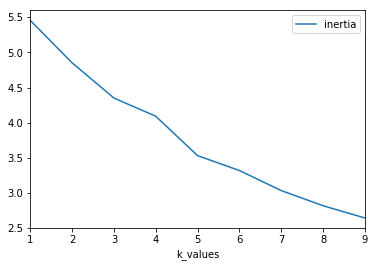

In [14]:
def mode(x):
    return x.mode()[0]
def freq(x):
    return '{0:.2f}%'.format(100 * x.value_counts()[0] / x.count())

def elbow_plot(df, label = 'k_values'):
    clustering = df.drop('Neighborhood', 1)
    keys = []
    interias = []
    for k in range (1, 10):
        kmeans_model = KMeans(n_clusters=k, random_state=0).fit(clustering)
        interia = kmeans_model.inertia_
        keys.append(k)
        interias.append(interia)
    s = pd.DataFrame({label: keys, 'inertia': interias})
    s.plot.line(x = label, y = "inertia")

elbow_plot(venues_onehot_micro)

In [15]:
def random_state_finder(one_hot_df, top_hitters_df, clusters):
    clustering = one_hot_df.drop('Neighborhood', 1)
    rs = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=clusters, random_state=i).fit(clustering)
        y = None
        y = np.bincount(kmeans.labels_)
        rs.append({'random_state' : i, 'deviation' : np.std(y), 'kmean' : kmeans})
    dev = min(f['deviation'] for f in rs)
    random_state = min(f['random_state'] for f in filter(lambda x: True if x['deviation'] == dev else False, rs))
    one_hot_df['Cluster'] = rs[random_state]['kmean'].labels_    
    top_hitters_df['Cluster'] = rs[random_state]['kmean'].labels_

random_state_finder(venues_onehot_micro, neighborhoods_venues_micro_sorted, 4)

neightborhood_df['Micro Cluster'] = neightborhood_df.name.map(lambda x: finder(x, venues_onehot_micro, 'Neighborhood', 'Cluster'))

cluster_nomeclator = neighborhoods_venues_micro_sorted.groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                               '1^ most common venue': [mode, freq],
                                                                '2^ most common venue': [mode, freq],
                                                                '3^ most common venue': [mode, freq],
                                                                '4^ most common venue': [mode, freq],
                                                                '5^ most common venue': [mode, freq]
                                                               })
cluster_nomeclator

Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                  4          Coffee Shop   75.00%                Hotel   
1                 54   Italian Restaurant   98.15%          Coffee Shop   
2                 27   Italian Restaurant   40.74%   Italian Restaurant   
3                  1            Gift Shop  100.00%           Fornitures   

                 3^ most common venue          4^ most common venue           \
            freq                 mode     freq                 mode     freq   
Cluster                                                                        
0         50.00%  American Restaurant   25.00%             Wine Bar   50.00%   
1         50.00%                 Snak   16.67%          Coffee Shop   14.81%   
2         29.63%          Coffee Shop   18.52%          Supermarket   14.81%   
3        100.00%             Wine Bar  100.00%        Grocery Store  100.00%   

        5^ most common venue           
                        mode     freq  
Cluster                                
0             Cosmetics Shop   25.00%  
1                        Gym   11.11%  
2                      Hotel   14.81%  
3          German Restaurant  100.00%

In [16]:
def map_builder(prop, original_df):
    kclusters = 10
    bins = len(original_df[prop].unique()) - 1
    n = folium.Map(location=PLACE, zoom_start=12, tiles='Stamen Toner')
    n.choropleth(geo_data=NEIGHTBORHOOD_FILE, data=original_df,  
             columns=['name', prop],
             key_on='feature.properties.NIL',
             fill_color='YlGnBu',
             fill_opacity=0.8,
             line_opacity=0.9,
             highlight = True,
             bins = bins,
             legend_name=prop)
    folium.LayerControl().add_to(n)
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    return n

map_builder('Micro Cluster', neightborhood_df)

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Elbow method for every category
Let's do that!

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


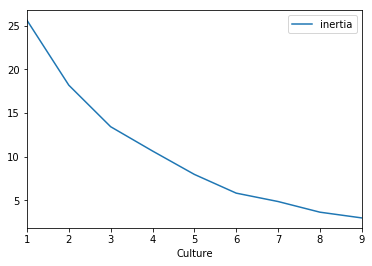

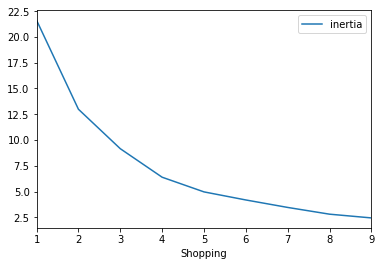

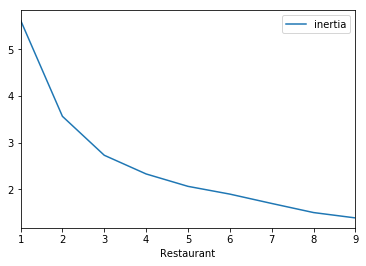

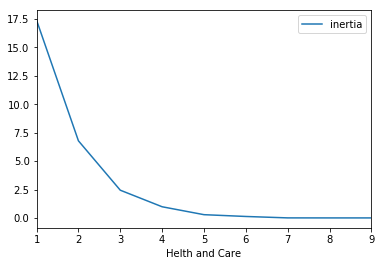

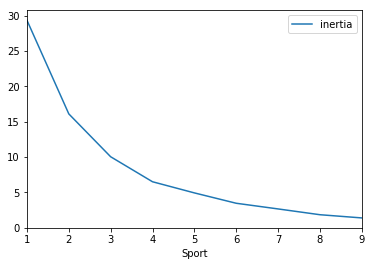

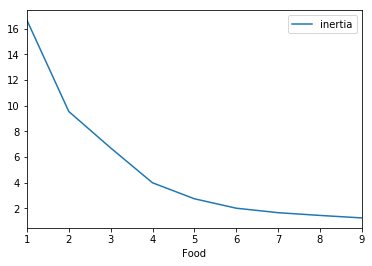

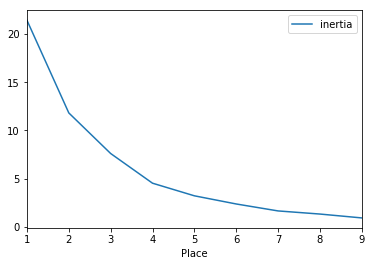

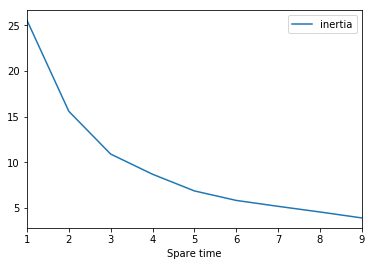

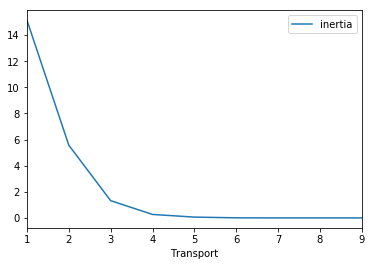

In [17]:
for category in DATASET.keys():
    elbow_plot(DATASET[category]['one_hot'], category)

In [18]:
ELBOW_ARRAY = [3, 4, 3, 3, 3, 4, 4, 4, 5, 3]
i = 0
for category in DATASET.keys():
    DATASET[category]['elbow'] = ELBOW_ARRAY[i]
    i = i+1

for category in DATASET.keys():
    random_state_finder(DATASET[category]['one_hot'], DATASET[category]['top_hitters'], DATASET[category]['elbow'])
    neightborhood_df['{} Cluster'.format(category)] = neightborhood_df.name.map(lambda x: finder(x, DATASET[category]['one_hot'], 'Neighborhood', 'Cluster'))
    print("\n\n***** " + category + " *****\n\n")
    try:
        print(DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   }))
    except:
        print(DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count',
                                                                            '1^ most common venue': [mode, freq],
                                                                            '2^ most common venue': [mode, freq],
                                                                            '3^ most common venue': [mode, freq]}))



***** Culture *****


        Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 18          Art Gallery   72.22%              Theater   
1                 30              Theater   43.33%              Theater   
2                 10              Theater  100.00%           Street Art   

                3^ most common venue         4^ most common venue          \
           freq                 mode    freq                 mode    freq   
Cluster                                                                     
0        61.11%           Street Art  83.33%               Museum  88.89%   
1        30.00%           Street Art  43.33%               Museum  46.67%   
2        80.00%               Museum  80.00%        Movie Theater  90.00%   

        5^ most common venue          
                       



***** Transport *****


        Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                  2          Bus Station  100.00%        Train Station   
1                 15        Train Station  100.00%          Bus Station   
2                  3     Airport Terminal  100.00%        Train Station   
3                  8          Bus Station  100.00%        Train Station   
4                  4        Train Station  100.00%          Bus Station   

                 3^ most common venue           
            freq                 mode     freq  
Cluster                                         
0        100.00%     Airport Terminal  100.00%  
1        100.00%     Airport Terminal  100.00%  
2        100.00%          Bus Station  100.00%  
3        100.00%     Airport Terminal  100.00%  
4        100.00%     Airport T

In [23]:
for category in DATASET.keys():
    m = map_builder('{} Cluster'.format(category), neightborhood_df)
    m.save(outfile = 'milan_data/map-{}.html'.format(category))
    print('Map of {}'.format(category))
    display(m)

Map of Culture


Map of Shopping


Map of Restaurant


Map of Helth and Care


Map of Sport


Map of Food


Map of Place


Map of Spare time


Map of Transport
